In [1]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from matplotlib import pyplot
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
import seaborn as sns
import lightgbm as lgb

---

# Carga de datos

In [2]:
train_auctions = pd.read_csv("../../features/entrenar_auctions_final.csv")

In [3]:
train_auctions.set_index("device_id", inplace=True)

In [4]:
train_auctions = train_auctions.reindex(sorted(train_auctions.columns), axis=1)

---

In [5]:
X_auctions, y_auctions = train_auctions.drop("target", axis=1), train_auctions["target"]

#filtro_auctions = (X_auctions.T.agg("sum") != 0)
#X_auctions = X_auctions.loc[filtro_auctions]
#y_auctions = y_auctions.loc[filtro_auctions]

X_train_auctions, X_test_auctions, y_train_auctions, y_test_auctions = \
    train_test_split(X_auctions, y_auctions, test_size=0.33, random_state=0)

In [6]:
dtrain_auctions = xgb.DMatrix(data=X_train_auctions, label=y_train_auctions)
dtest_auctions = xgb.DMatrix(data=X_test_auctions, label=y_test_auctions)

---

In [7]:
train_installs = pd.read_csv("../../features/entrenar_installs_final.csv")
train_installs.set_index("device_id", inplace=True)
train_installs = train_installs.reindex(sorted(train_installs.columns), axis=1)

---

In [8]:
X_installs, y_installs = train_installs.drop("target", axis=1), train_installs["target"]
X_train_installs, X_test_installs, y_train_installs, y_test_installs = \
    train_test_split(X_installs, y_installs, test_size=0.33, random_state=0)

#filtro_installs = (X_installs.T.agg("sum") != 0)
#X_installs = X_installs.loc[filtro_installs]
#y_installs = y_installs.loc[filtro_installs]

In [9]:
dtrain_installs = xgb.DMatrix(data=X_train_installs, label=y_train_installs)
dtest_installs = xgb.DMatrix(data=X_test_installs, label=y_test_installs)

---

# XGBoost

In [10]:
# {'colsample_bytree': 0.9500000000000001, 'eta': 0.35000000000000003, 'gamma': 0.9, 'max_depth': 6, 'min_child_weight': 2.0, 'n_estimators': 168}
best_auctions = {
        'n_estimators': 168,
        'eta': 0.35,
        'max_depth': 6,
        'min_child_weight': 2.0,
        'gamma': 0.9,
        'colsample_bytree': 0.95,
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}
model_auctions = xgb.train(best_auctions, dtrain_auctions, verbose_eval=False)

In [11]:
best_installs = {
        'n_estimators': 500,
        'eta': 0.4,
        'max_depth': 3,
        'min_child_weight': 0.5,
        'gamma': 0.65,
        'colsample_bytree': 0.85,
        'eval_metric': 'rmse',
        'obj': 'reg:squarederror',
        'nthread': 6,
        'booster': 'gbtree',
        'tree_method': 'exact',
        'silent': 1,
}
model_installs = xgb.train(best_installs, dtrain_installs, verbose_eval=False)

---

# LightGBM

In [12]:
lgb_auctions = lgb.LGBMRegressor()
lgb_auctions.fit(X_train_auctions, y_train_auctions)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [13]:
lgb_installs = lgb.LGBMRegressor()
lgb_installs.fit(X_train_installs, y_train_installs)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

---

In [14]:
pred_auctions_xgb = model_auctions.predict(dtest_auctions)

In [15]:
pred_installs_xgb = model_installs.predict(dtest_installs)

In [16]:
pred_auctions_l = lgb_auctions.predict(X_test_auctions)

In [17]:
pred_installs_l = lgb_installs.predict(X_test_installs)

In [18]:
def rmsetotal(preds_a, preds_i):
    auctions = mean_squared_error(preds_a, y_test_auctions)
    installs = mean_squared_error(preds_i, y_test_installs)
    return sqrt((auctions+installs)/2)

In [19]:
rmsetotal(pred_auctions_xgb, pred_installs_xgb)

71627.61600006236

In [20]:
rmsetotal(pred_auctions_l, pred_installs_l)

71611.51468456266

In [21]:
pred_promedio_a = (0.4*pred_auctions_xgb + 0.6*pred_auctions_l)

In [22]:
pred_promedio_i = (0.4*pred_installs_xgb + 0.6*pred_installs_l)

In [23]:
rmsetotal(pred_promedio_a, pred_promedio_i)

71602.81421431414

# Prueba sesgado

In [13]:
(X_installs.T.agg("sum") == 0).value_counts()

False    737575
True     312769
dtype: int64

In [16]:
minicopia = X_installs.head().copy()

In [21]:
minicopia.T.agg("sum") != 0

device_id
4432995619177048534    True
5904733559638204455    True
896373747754111825     True
3399210824535017892    True
1541425881979513687    True
dtype: bool

In [10]:
X_installs = X_installs.loc[filtro]

In [11]:
y_installs = y_installs.loc[filtro]

In [9]:
filtro = (X_installs.T.agg("sum") != 0)

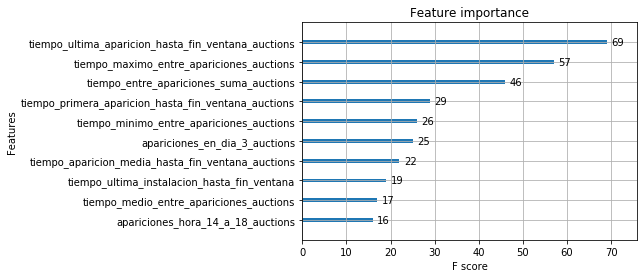

In [25]:
xgb.plot_importance(model_auctions, max_num_features=10)

In [34]:
sqrt(mean_squared_error(pred_installs_l, y_test_installs))

76413.03003730433

---

# Random Forest

In [3]:
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler

/opt/anaconda/3/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


In [8]:
def rfr_model(X, y):# Perform Grid-Search
    gsc = GridSearchCV(
        estimator=RandomForestRegressor(),
        param_grid={
            'max_depth': range(3,7),
            'n_estimators': (10, 50, 100, 1000),
        },
        cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)
    
    grid_result = gsc.fit(X, y)
    best_params = grid_result.best_params_
    
    rfr = RandomForestRegressor(max_depth=best_params["max_depth"], n_estimators=best_params["n_estimators"],
                                random_state=False, verbose=False)# Perform K-Fold CV
    scores = cross_val_score(rfr, X, y, cv=10, scoring='neg_mean_squared_error')
    print(best_params)
    return scores

In [9]:
rfr_model(X_installs.fillna(0), y_installs)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


KeyboardInterrupt: 

In [11]:
regr = RandomForestRegressor(max_depth=2, random_state=0, n_estimators=100, n_jobs=6)

regr.fit(X_train_installs.fillna(0), y_train_installs)


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [15]:
sqrt(mean_squared_error(regr.predict(X_test_installs.fillna(0)), y_test_installs))

76415.41162606733

In [19]:
preds_installs_random = regr.predict(X_test_installs.fillna(0))

In [34]:
from sklearn.feature_selection import SelectFromModel

In [37]:
sel = SelectFromModel(RandomForestRegressor(n_estimators = 100, n_jobs=6))
sel.fit(X_train_installs.fillna(0), y_train_installs)

SelectFromModel(estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=6,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
        norm_order=1, prefit=False, threshold=None)

In [55]:
importantes = list(sel.get_support())

In [56]:
columnas = list(X_train_installs.columns.values)

In [57]:
seleccionadas = [columnas[x] for x in range(len(importantes)) if importantes[x]]

In [61]:
X_train_installs[seleccionadas]

,apariciones_en_dia_1_auctions,apariciones_en_dia_2_auctions,apariciones_en_dia_3_auctions,apariciones_en_source_0_auctions,apariciones_en_source_1_auctions,apariciones_en_source_3_auctions,apariciones_en_source_4_auctions,apariciones_en_source_6_auctions,apariciones_en_source_7_auctions,apariciones_en_source_8_auctions,...,tiempo_aparicion_media_hasta_fin_ventana_auctions,tiempo_desde_hora_mas_frecuente_hasta_00_events,tiempo_entre_apariciones_suma_auctions,tiempo_maximo_entre_apariciones_auctions,tiempo_medio_entre_apariciones_auctions,tiempo_minimo_entre_apariciones_auctions,tiempo_minimo_entre_apariciones_events,tiempo_primera_aparicion_hasta_fin_ventana_auctions,tiempo_ultima_aparicion_hasta_fin_ventana_auctions,tiempo_ultima_instalacion_hasta_fin_ventana
device_id,,,,,,,,,,,,,,,,,,,,,
6338225059960244266,NaN,NaN,1.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,0.000000,7200.0,0.000000,NaN,NaN,NaN,8173.492,4549.095737,4549.095737,110747.161
5427466112113828338,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.0,NaN,NaN,NaN,NaN,0.668,NaN,NaN,191871.154
4516621068153122762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6063131322164121880,1.0,4.0,NaN,NaN,NaN,2.0,NaN,NaN,1.0,NaN,...,68411.436901,NaN,86802.978768,84944.753099,21700.744692,0.001033,NaN,192812.350826,106009.372058,NaN
5097806747771477658,NaN,NaN,2.0,NaN,2.0,NaN,NaN,NaN,NaN,NaN,...,21.754308,NaN,43.508616,43.508616,43.508616,43.508616,NaN,16944.714524,16901.205908,NaN
5863292819394946163,13.0,NaN,12.0,9.0,8.0,7.0,NaN,NaN,NaN,1.0,...,117787.353270,NaN,223757.908247,89501.269137,9323.246177,0.245585,NaN,255964.768042,32206.859795,NaN
3712835382288504516,NaN,NaN,3.0,3.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.851381,NaN,10.247163,8.940183,5.123582,1.306980,NaN,9676.714678,9666.467515,NaN
6479315174887396446,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1459144335310591662,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
lgb_installs = lgb.LGBMRegressor()
lgb_installs.fit(X_train_installs[seleccionadas], y_train_installs)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
       n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
       random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
       subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

---

In [63]:
pred_installs_l = lgb_installs.predict(X_test_installs[seleccionadas])

In [64]:
sqrt(mean_squared_error(pred_installs_l, y_test_installs))

76417.03606183069